# Tech challenge - Grupo 9 - É chikungunya?

Criar um modelo que consiga dizer se uma pessoa tem chikungunya.

## Sobre o projeto

A base utilizada foi do portal do [gov.br - dados abertos](https://dadosabertos.saude.gov.br/) com os dados de notificações de pessoas com possível chikungunya.

### Dicionário de dados das colunas utilizadas

Sinais clínicos - 1 Sim / 2 Não
- FEBRE : Febre
- MIALGIA: Mialgia
- CEFALEIA: Cefaleia
- EXANTEMA: Exantema
- VOMITO: Vômito
- NAUSEA: Náusea
- DOR_COSTAS: Dor nas costas
- CONJUNTVIT: Conjuntivite
- ARTRITE: Artrite
- ARTRALGIA: Artralgia intensa
- PETEQUIA_N: Petéquias
- LEUCOPENIA: Leucopenia
- LACO: Prova do laço
- DOR_RETRO: Dor retroorbital

Comorbidades - 1 Sim / 2 Não
- DIABETES: Diabetes
- HEMATOLOG: Doenças hematológicas
- HEPATOPAT: Hepatopatias
- RENAL: Doença renal crônica
- HIPERTENSA: Hipertensão arterial
- ACIDO_PEPT: Doença ácido-péptica
- AUTO_IMUNE: Doenças auto-imunes

Exames
- HISTOPA_N: Resultado Histopatologia - 1 Reagente / 2  Não Reagente / 3 Inconclusivo / 4 Não realizado
- IMUNOH_N: Resultado Imunohistoquímica - 1 Reagente / 2  Não Reagente / 3 Inconclusivo / 4 Não realizado
- RESUL_PCR: RT-PCR Resultado - 1 Reagente / 2  Não Reagente / 3 Inconclusivo / 4 Não realizado
- RESUL_VI_N: Isolamento Viral Resultado - 1 Reagente / 2  Não Reagente / 3 Inconclusivo / 4 Não realizado
- RESUL_PRNT: Exame PRNT Resultado - 1 Reagente / 2  Não Reagente / 3 Inconclusivo / 4 Não realizado
- CLINC_CHIK: Apresentação clínica Chikungunya - 1 Aguda / 2 Crônica

Target
- CLASSI_FIN: 
	- 5 Não tem chikungunya / 13 = Tem dengue chikungunya

Dados
- NU_IDADE_N: Idade
- ID_MN_RESI: Município de residência

[Dicionário de dados completo](./dic_dados_chikungunya.pdf) (PDF)

### Resumo

Dataset original contém 245.541 registros com 122 características/colunas.

54 colunas estão com mais de 99% em branco e foram removidas. 

Os algoritmos testados foram: 
- Liner Regression
- Random Forest Regressorn
- Random Forest Classifier
- KNeighbors Classifier
- XGBoost
- LightGBM


### Links Úteis

- [Informações sobre a base de dados](https://dadosabertos.saude.gov.br/dataset/arboviroses-febre-de-chikungunya) (link externo)
- [Base de dados 2025](./dados/CHIKBR25.csv) (CSV)


## Variáveis auxiliares

- df_original: valor do dataframe sem modificação
- df_original_without_null_columns: valor do dataframe original sem 54 colunas que possuiam +99% de valores nulos
- df: valor do dataframe modificado ao longo dos blocos
- cols_sintomas: nomes de colunas relacionadas a sintomas
- cols_comorbidades: nomes de colunas relacionadas a sintomas 
- cols_exames: nomes de colunas relacionadas a exame
- col_target: nome da coluna target
- colunas_selecionada: soma de todas as colunas

## Requisitos

In [1]:
%%capture 

! pip install -r requirements.txt

## Importações e configurações

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df_original = pd.read_csv("./dados/CHIKBR25.csv", low_memory=False)
df_original.head()

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,SEM_PRI,ANO_NASC,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_PAIS,DT_INVEST,ID_OCUPA_N,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,DT_CHIK_S1,DT_CHIK_S2,DT_PRNT,RES_CHIKS1,RES_CHIKS2,RESUL_PRNT,DT_SORO,RESUL_SORO,DT_NS1,RESUL_NS1,DT_VIRAL,RESUL_VI_N,DT_PCR,RESUL_PCR_,SOROTIPO,HISTOPA_N,IMUNOH_N,HOSPITALIZ,DT_INTERNA,UF,MUNICIPIO,TPAUTOCTO,COUFINF,COPAISINF,COMUNINF,CLASSI_FIN,CRITERIO,DOENCA_TRA,CLINC_CHIK,EVOLUCAO,DT_OBITO,DT_ENCERRA,ALRM_HIPOT,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,DT_ALRM,GRAV_PULSO,GRAV_CONV,GRAV_ENCH,GRAV_INSUF,GRAV_TAQUI,GRAV_EXTRE,GRAV_HIPOT,GRAV_HEMAT,GRAV_MELEN,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,DT_GRAV,MANI_HEMOR,EPISTAXE,GENGIVO,METRO,PETEQUIAS,HEMATURA,SANGRAM,LACO_N,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,NU_LOTE_I,TP_SISTEMA,NDUPLIC_N,DT_DIGITA,CS_FLXRET,FLXRECEBI,MIGRADO_W
0,2,A920,2024-12-30,202501,2024,32,320060,32001.00,2449218.00,2024-12-30,202501,1989.00,4035,F,5.00,1,6.00,32,320060.00,32001.00,1,2024-12-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,4.00,NaN,4.00,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
1,2,A920,2024-12-30,202501,2024,32,320405,32003.00,2484536.00,2024-12-29,202501,1980.00,4044,M,5.00,4,9.00,32,320405.00,32003.00,1,2024-12-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,1.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,13.00,1.00,NaN,NaN,1.00,NaN,2025-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
2,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,1996.00,4028,M,6.00,4,9.00,32,320130.00,32002.00,1,2024-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
3,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,1979.00,4045,F,5.00,1,9.00,32,320130.00,32002.00,1,2024-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
4,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,2008.00,4016,F,5.00,4,9.00,32,320130.00,32002.00,1,2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN

## Criação de variaveis

In [4]:
cols_sintomas = [
		'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS',
		'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO',
		'DOR_RETRO'
]

cols_comorbidades = [
		'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA',
		'ACIDO_PEPT', 'AUTO_IMUNE', 
]

cols_exames = [
		# 'HISTOPA_N', 'IMUNOH_N', 'RESUL_PCR_', 'RESUL_VI_N', 
		# 'RESUL_PRNT'
]

col_target = [
		'CLASSI_FIN', 
]

# Colunas adicionais para análise de contexto e fatores demográficos
colunas_adicionais = [
	'NU_IDADE_N', 
	'ID_MN_RESI', 
]

colunas_selecionadas = cols_sintomas + cols_comorbidades + cols_exames + colunas_adicionais + col_target

df = df_original[colunas_selecionadas].copy()

## Análise Exploratória de Dados (EDA)

In [5]:
# Quantidade de linhas e colunas
df_original.shape

(248541, 122)

In [6]:
# Analisando as informações do dataset
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248541 entries, 0 to 248540
Columns: 122 entries, TP_NOT to MIGRADO_W
dtypes: float64(94), int64(10), object(18)
memory usage: 231.3+ MB


### A coluna target está equilibrada? 

- 5 = Não tem chikungunya
- 13 = Tem chikungunya


Observação: A quantidade entre casos com e sem chickungunya está bem parecido

In [7]:
df['TARGET'] = df['CLASSI_FIN'].map({13.0: 1, 5.0: 0})
df = df.dropna(subset=['CLASSI_FIN'])

(array([118495.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 108185.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

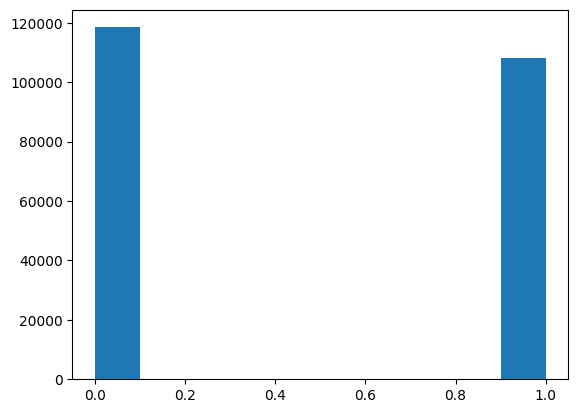

In [8]:
plt.hist(df['TARGET']) 

### Analise NU_ANO

In [9]:
df_original['NU_ANO'].value_counts()

NU_ANO
2025    248317
2024       200
2026        24
Name: count, dtype: int64

*Curiosidade:* a coluna "NU_ANO" indica que há notificações fora do ano de 2025. Isso é possível pois ocorreu a notificacao final de 2024, mas a analise dos sintomas foi concluído em 2025.

In [10]:
df_original.loc[df_original['NU_ANO'] == 2024, ['NU_ANO', 'DT_ENCERRA']].head()

,NU_ANO,DT_ENCERRA
0,2024,2025-01-17
1,2024,2025-01-17
2,2024,2025-02-04
3,2024,2025-02-04
4,2024,2025-02-04


### Análise e tratamento de Valores Nulos


<Axes: >

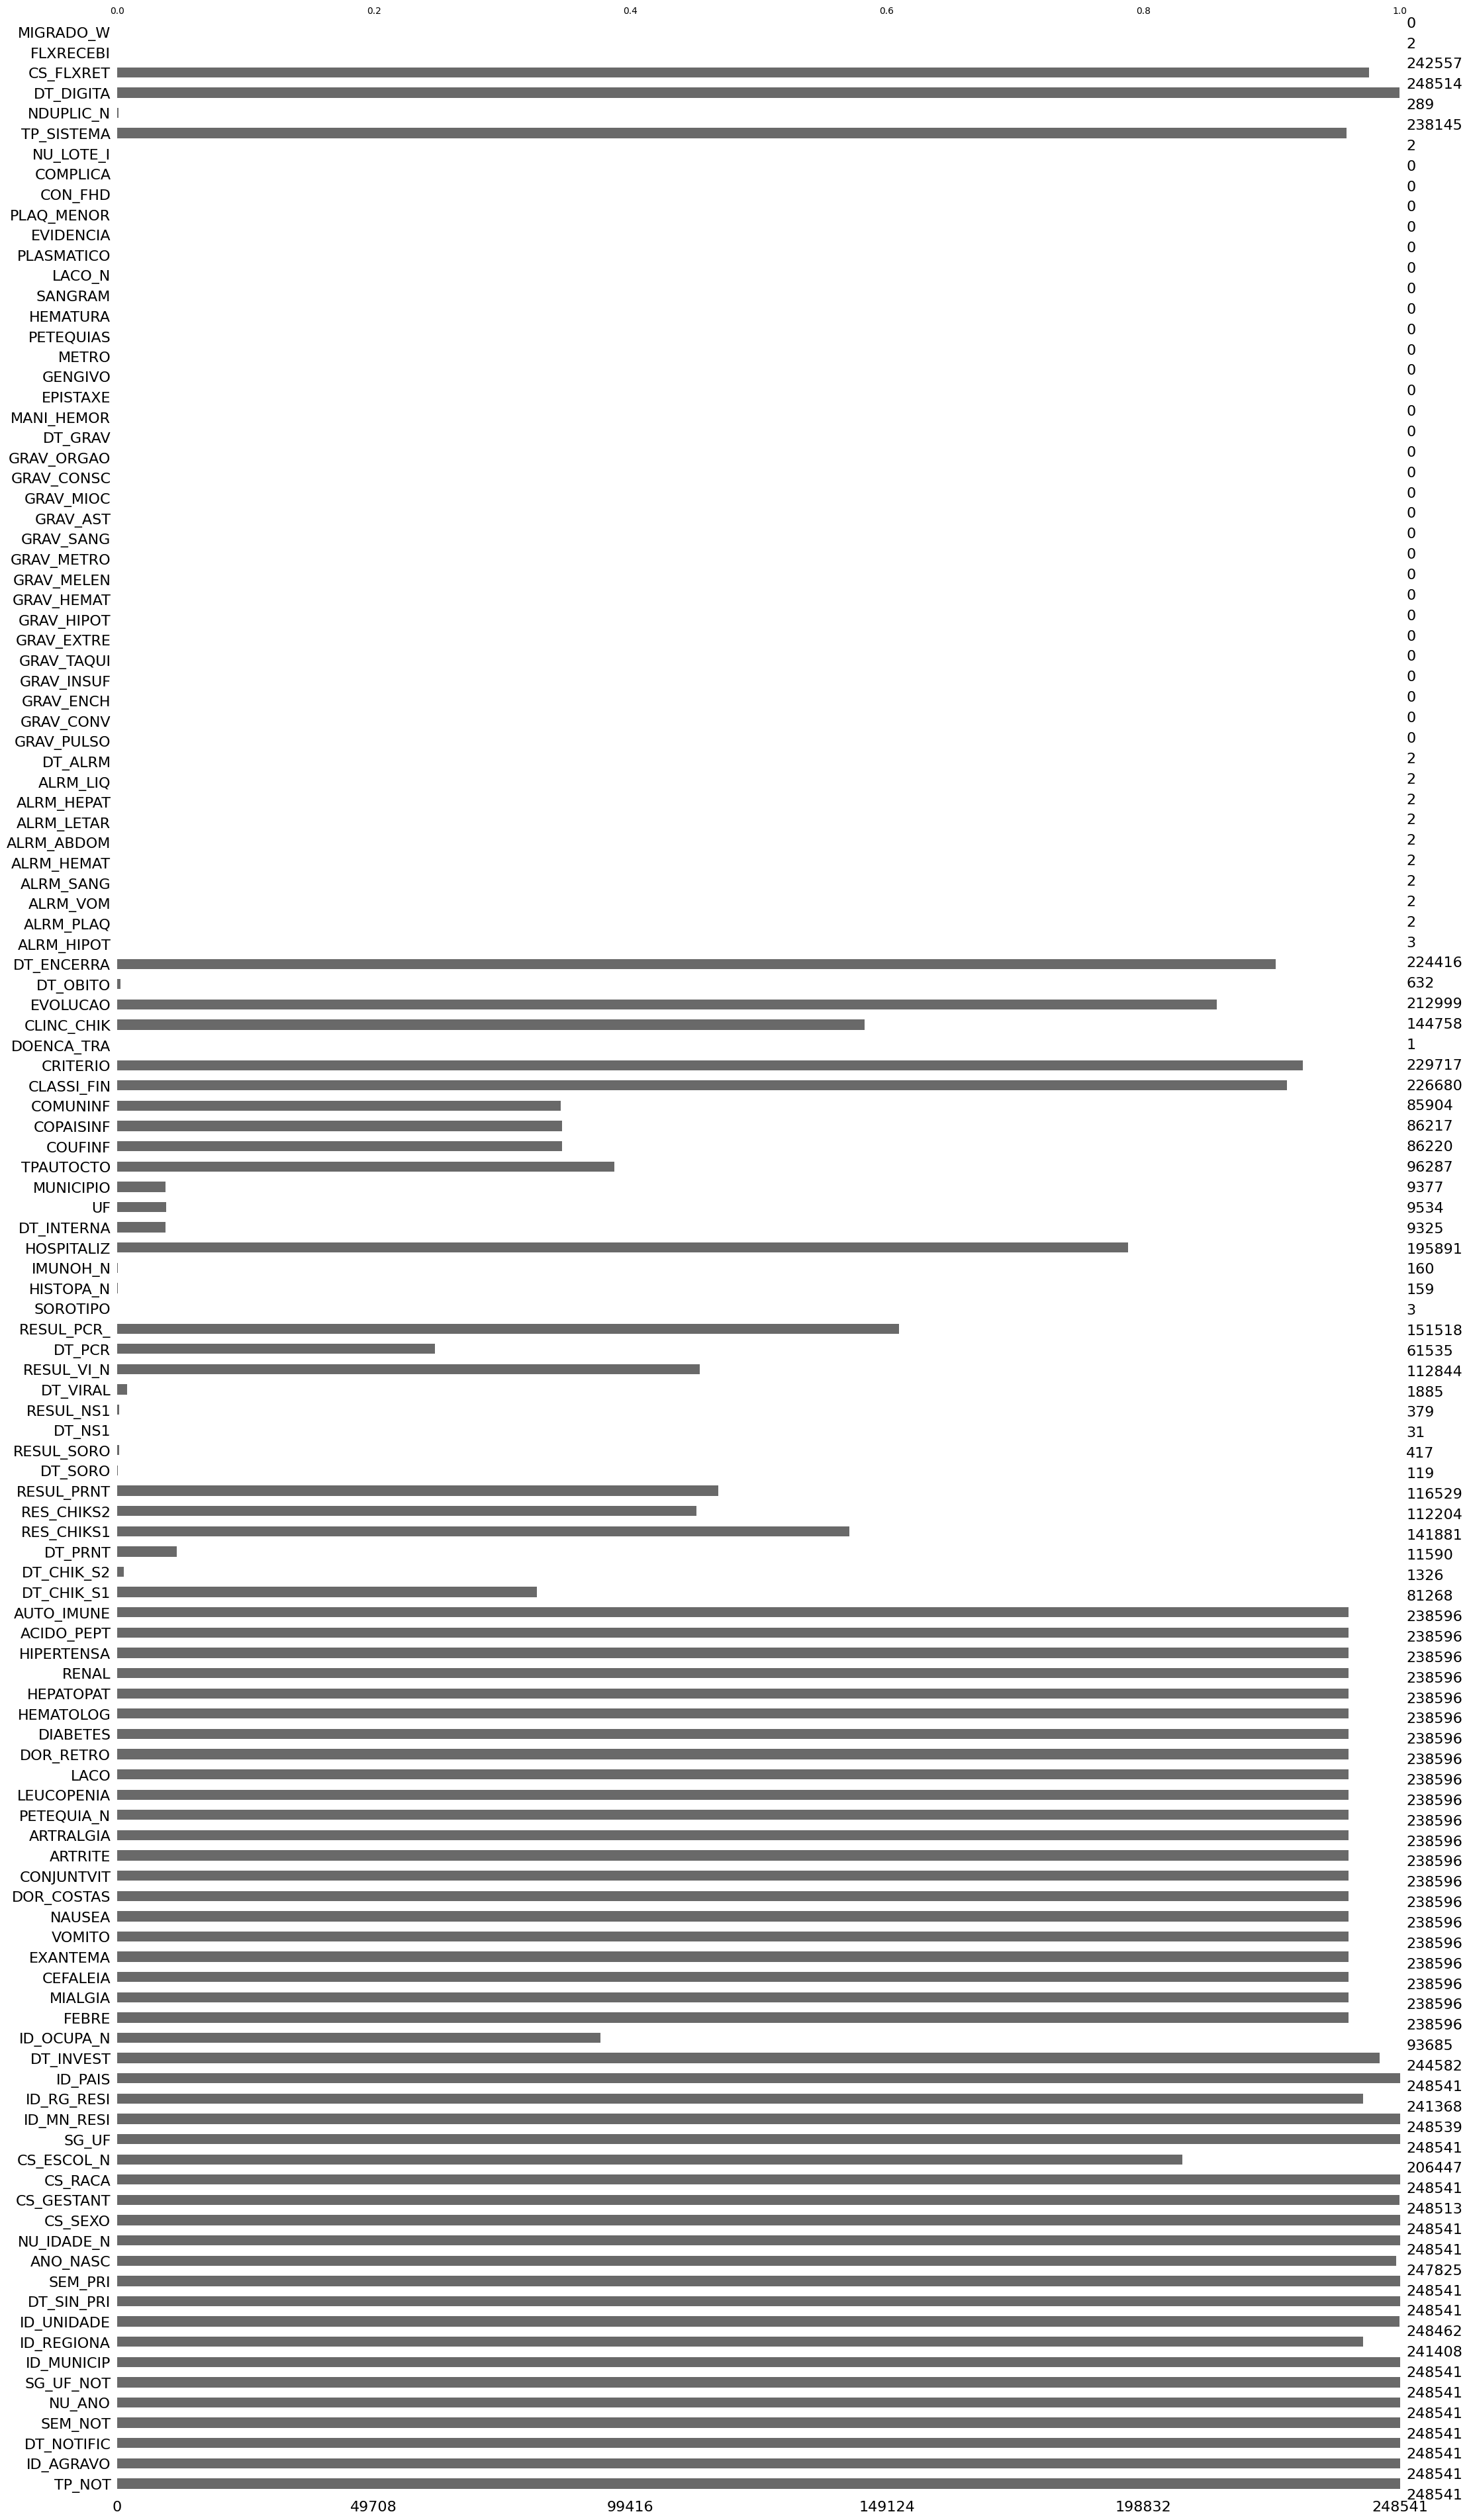

In [11]:
msno.bar(df_original)

In [12]:
# Remover colunas com mais de 99% de valores nulos
null_ratio = df.isnull().mean()
null_threshold = 0.99

# Identificar colunas que serão removidas
colunas_para_remover = null_ratio[null_ratio >= null_threshold].index.tolist()
print(f"\nColunas que serão removidas (>= {null_threshold*100}% nulos): {colunas_para_remover}")
print(f"Total de colunas a remover: {len(colunas_para_remover)}")

# Remover colunas com mais de 99% de valores nulos
df = df.loc[:, df.isnull().mean() < null_threshold]

print(f"\nApós remoção por nulos: {df.shape}")


Colunas que serão removidas (>= 99.0% nulos): []
Total de colunas a remover: 0

Após remoção por nulos: (226680, 25)


<Axes: >

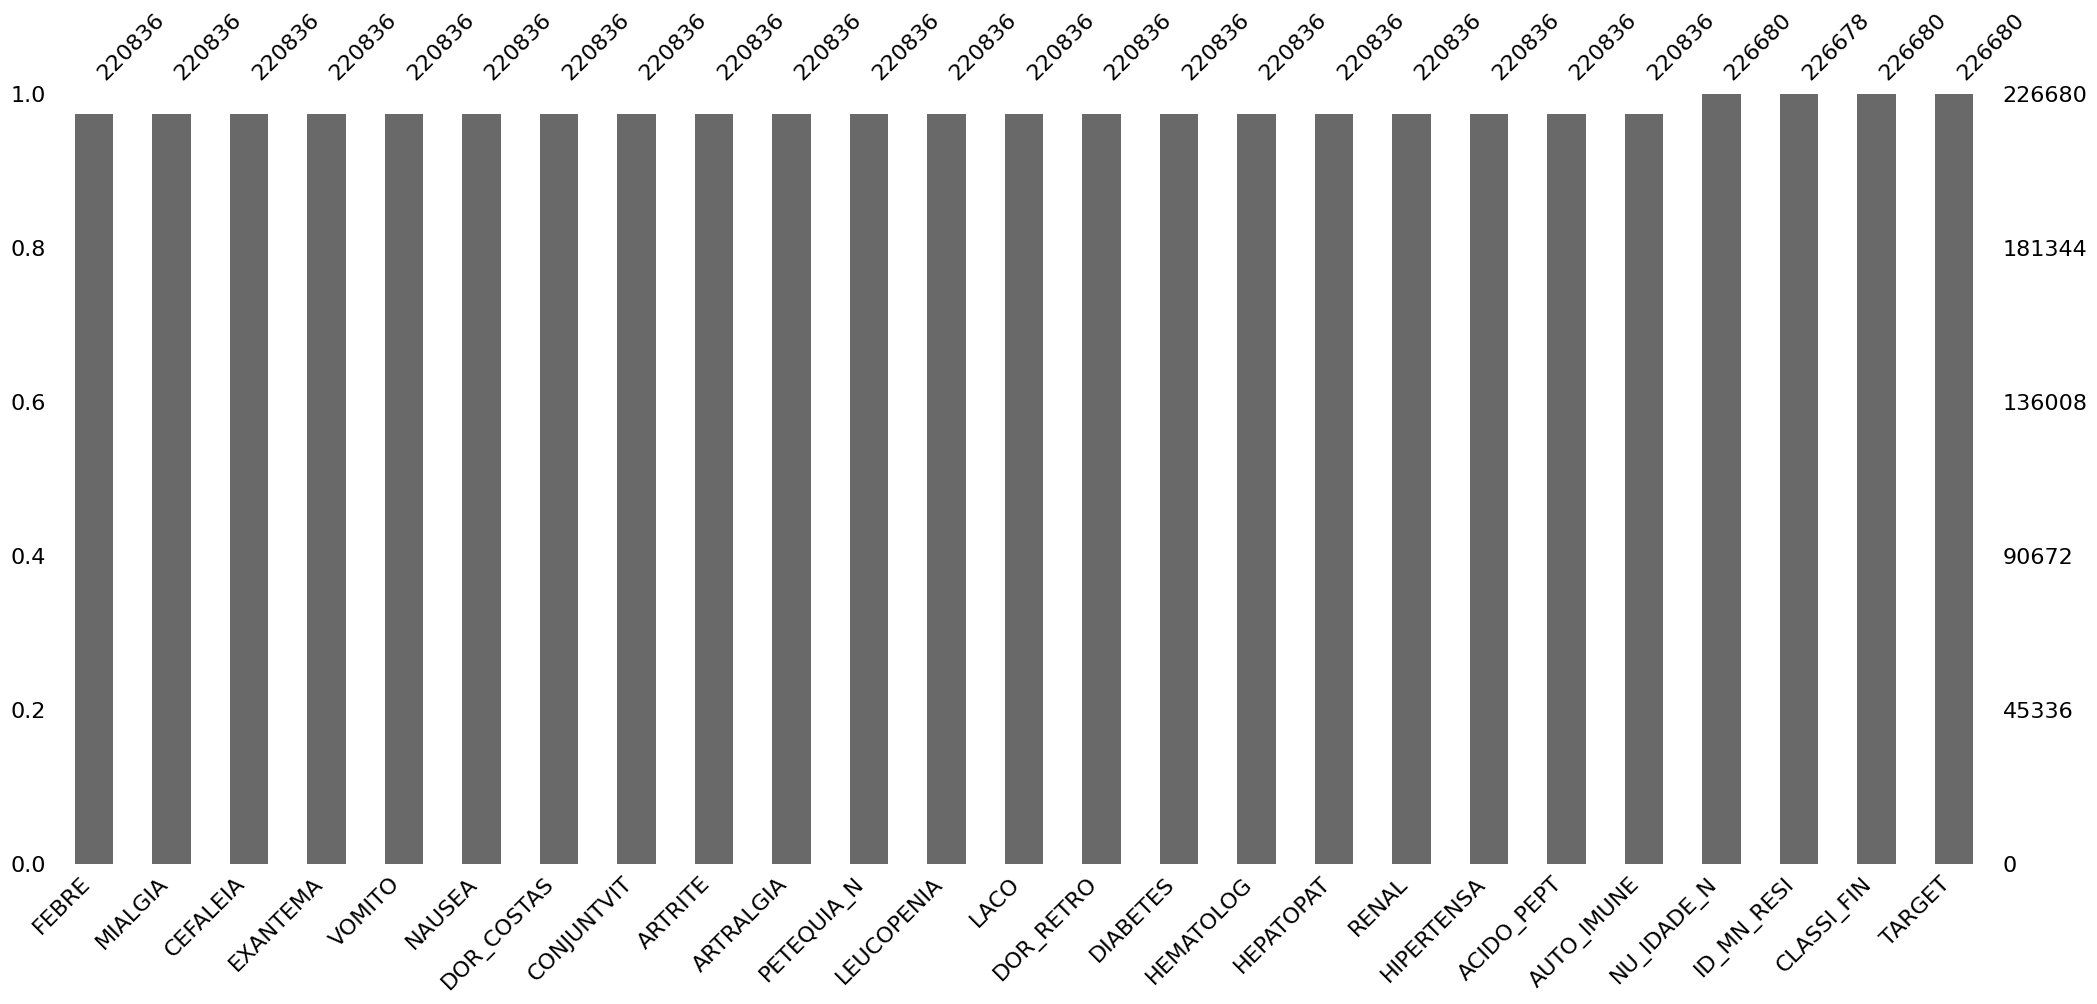

In [13]:
msno.bar(df)

### Removendo linhas que possuem a "CLASSI_FIN" ( tagert ) null

Essa é a nossa variavel alvo, não faz sentido preencher esses valores aleatoriamente, pois pode trazer algum vies errado

In [14]:
linhas_com_classi_fin_nulo = df["TARGET"].isnull().sum()
print(f"Excluir {linhas_com_classi_fin_nulo} linhas nulas em CLASSI_FIN")

# Removendo as linhas nulas
df = df[df["TARGET"].notnull()]
df.shape[0]

Excluir 0 linhas nulas em CLASSI_FIN


226680

In [15]:
linhas_com_febre_nulo = df["FEBRE"].isnull().sum()
print(f"Excluir {linhas_com_febre_nulo} linhas nulas em febre")

# Removendo as linhas nulas
df = df[df["FEBRE"].notnull()]
linhas_depois = df.shape[0]

Excluir 5844 linhas nulas em febre


In [16]:
linhas_com_mialgia_nulo = df["MIALGIA"].isnull().sum()
print(f"Excluir {linhas_com_mialgia_nulo} linhas nulas em mialgia")

Excluir 0 linhas nulas em mialgia


In [17]:
# Colunas com valores nulos

df.isnull().sum().sort_values(ascending=False)

ID_MN_RESI    2
FEBRE         0
DOR_RETRO     0
CLASSI_FIN    0
NU_IDADE_N    0
AUTO_IMUNE    0
ACIDO_PEPT    0
HIPERTENSA    0
RENAL         0
HEPATOPAT     0
HEMATOLOG     0
DIABETES      0
LACO          0
MIALGIA       0
LEUCOPENIA    0
PETEQUIA_N    0
ARTRALGIA     0
ARTRITE       0
CONJUNTVIT    0
DOR_COSTAS    0
NAUSEA        0
VOMITO        0
EXANTEMA      0
CEFALEIA      0
TARGET        0
dtype: int64

### Influencia Resultado Exame PCR

Quantos exames reagentes tiveram diagnostico como negativo? E quantos não reagentes tiveram diagnostivo positivo?

In [18]:
pd.crosstab(df_original['RESUL_PCR_'], df['TARGET'])

TARGET,0.00,1.00
RESUL_PCR_,,
1.00,182,18558
2.00,36993,1896
3.00,80,83
4.00,38006,47983


array([[<Axes: title={'center': 'FEBRE'}>,
        <Axes: title={'center': 'MIALGIA'}>,
        <Axes: title={'center': 'CEFALEIA'}>,
        <Axes: title={'center': 'EXANTEMA'}>,
        <Axes: title={'center': 'VOMITO'}>],
       [<Axes: title={'center': 'NAUSEA'}>,
        <Axes: title={'center': 'DOR_COSTAS'}>,
        <Axes: title={'center': 'CONJUNTVIT'}>,
        <Axes: title={'center': 'ARTRITE'}>,
        <Axes: title={'center': 'ARTRALGIA'}>],
       [<Axes: title={'center': 'PETEQUIA_N'}>,
        <Axes: title={'center': 'LEUCOPENIA'}>,
        <Axes: title={'center': 'LACO'}>,
        <Axes: title={'center': 'DOR_RETRO'}>,
        <Axes: title={'center': 'DIABETES'}>],
       [<Axes: title={'center': 'HEMATOLOG'}>,
        <Axes: title={'center': 'HEPATOPAT'}>,
        <Axes: title={'center': 'RENAL'}>,
        <Axes: title={'center': 'HIPERTENSA'}>,
        <Axes: title={'center': 'ACIDO_PEPT'}>],
       [<Axes: title={'center': 'AUTO_IMUNE'}>,
        <Axes: title={'cente

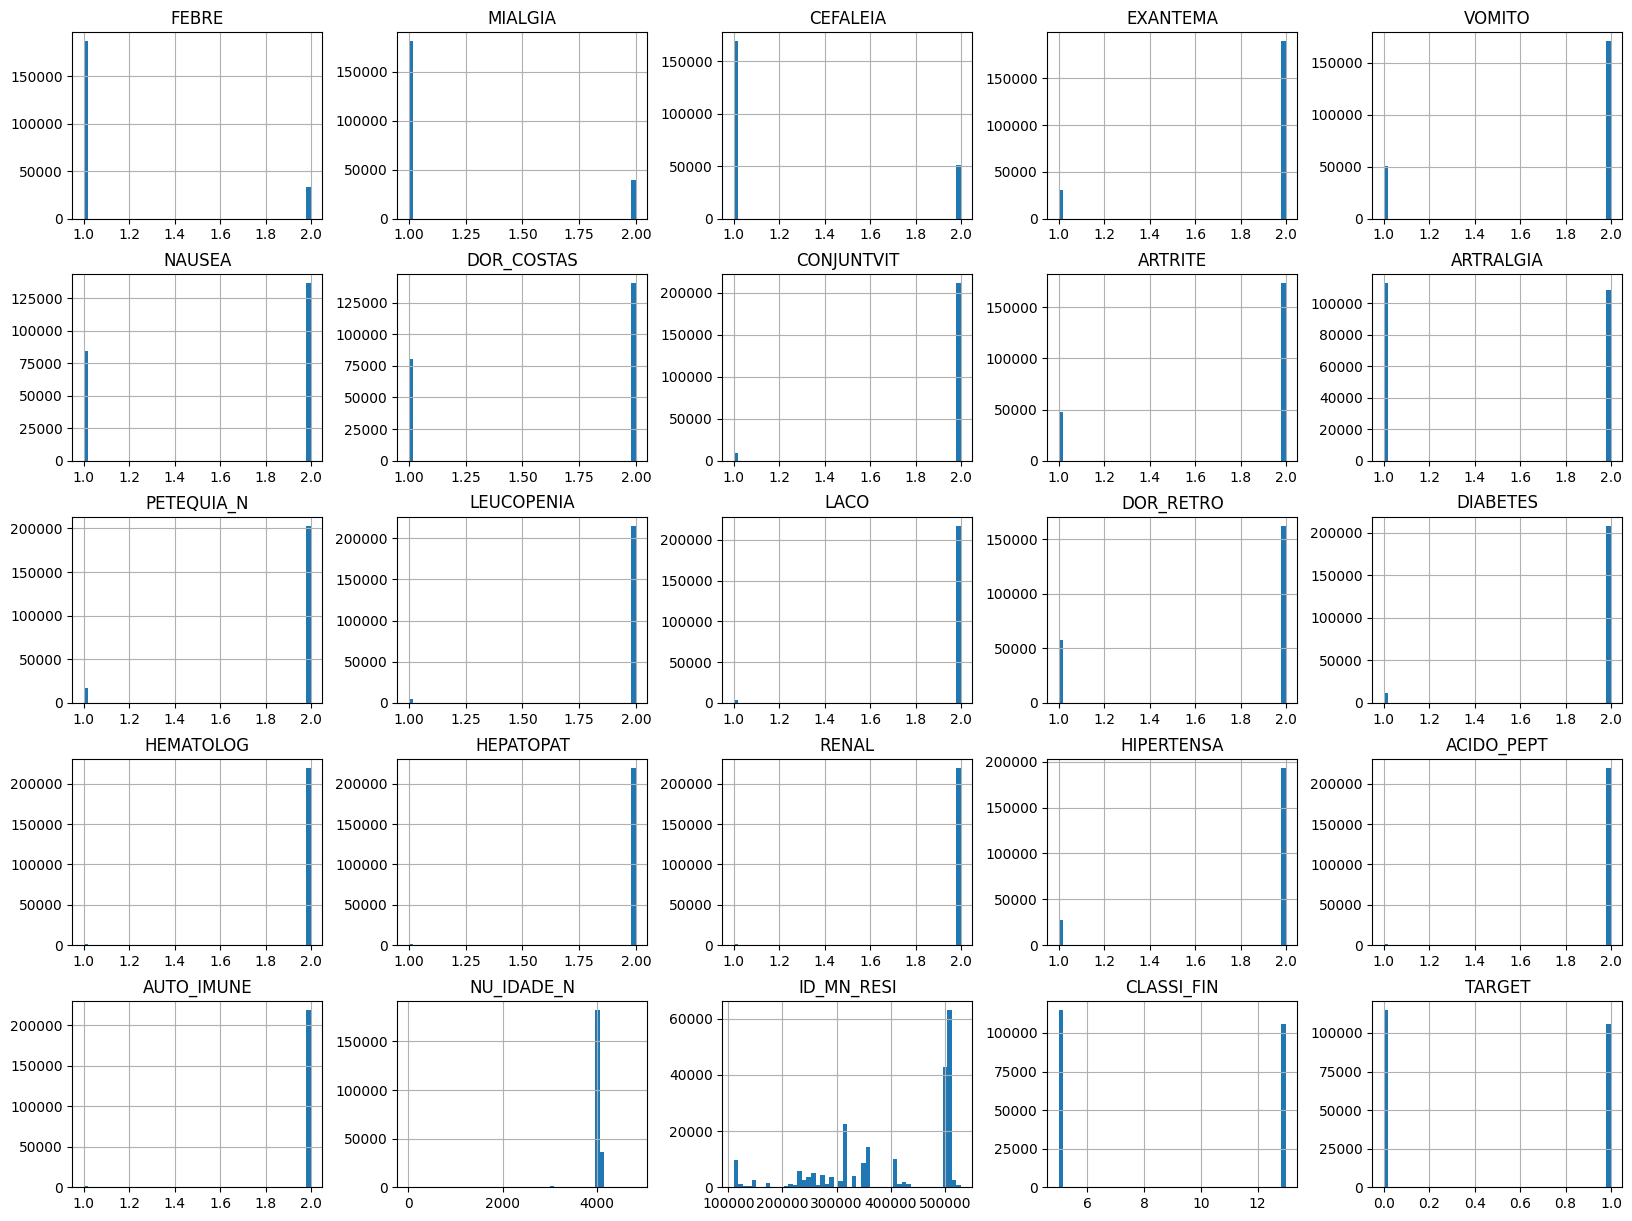

In [19]:
df.hist(bins=50, figsize=(20, 15))

## Tratamento de campos

In [20]:
# Tratamento do campo idade

def converter_idade(idade):
    if pd.isna(idade): return 0
    if idade >= 4000: return idade - 4000 # Anos
    if idade >= 3000: return (idade - 3000) / 12 # Meses convertido para anos
    if idade >= 2000: return (idade - 2000) / 365 # Dias convertido para anos
    return 0

df['IDADE_REAL'] = df['NU_IDADE_N'].apply(converter_idade)

df = df.drop(columns=['NU_IDADE_N'])

df['IDADE_REAL'].value_counts()



IDADE_REAL
30.00     4016
29.00     3961
42.00     3932
28.00     3916
25.00     3907
27.00     3887
26.00     3863
43.00     3839
24.00     3826
37.00     3790
19.00     3773
20.00     3770
31.00     3747
38.00     3747
36.00     3739
23.00     3736
39.00     3724
22.00     3672
35.00     3672
40.00     3666
45.00     3664
32.00     3652
44.00     3638
41.00     3624
34.00     3590
33.00     3530
47.00     3523
21.00     3520
46.00     3458
49.00     3352
18.00     3251
48.00     3234
50.00     3144
52.00     3025
16.00     3010
51.00     3006
17.00     3000
53.00     2911
54.00     2884
56.00     2811
55.00     2763
15.00     2746
14.00     2708
12.00     2635
10.00     2626
57.00     2625
13.00     2586
11.00     2539
58.00     2471
9.00      2462
59.00     2448
60.00     2413
61.00     2387
8.00      2229
62.00     2208
7.00      2139
6.00      2082
63.00     2048
65.00     2041
64.00     2014
67.00     1808
66.00     1787
5.00      1783
68.00     1591
1.00      1580
4.00      1578

In [21]:
# Criar Faixas Etárias 
def categorizar_idade(idade):
    if idade <= 12: return 0  # Criança
    if idade <= 18: return 1  # Adolescente
    if idade <= 60: return 2  # Adulto
    return 3                  # Idoso (Grupo de risco para Chikungunya)

df['FAIXA_ETARIA'] = df['IDADE_REAL'].apply(categorizar_idade)

df = df.drop(columns=['IDADE_REAL'])

df['FAIXA_ETARIA'].value_counts()

FAIXA_ETARIA
2    145469
3     31126
0     26940
1     17301
Name: count, dtype: int64

## Análise de correlação

Análise de correlação para todas as colunas numéricas, comparando com nossa variável alvo ("**CLASSI_FIN**", que representa o diagnóstico final).

Primeiramente, vamos descartar todos as colunas para as quais 99% dos dados estejam ausentes, assim não sobrecarrega a correlação com todas as colunas

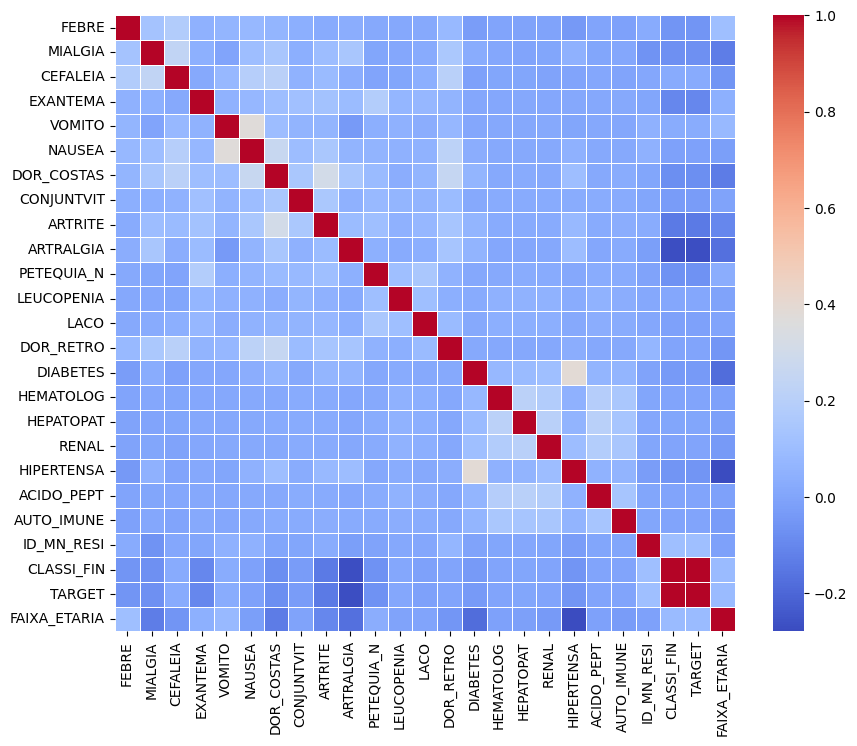

In [22]:
df_corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))

sns.heatmap(df_corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.show()

In [23]:
df_corr_target = df.select_dtypes(include=[np.number]).corr()['TARGET']

df_nulos_contagem = df.isnull().sum()

df_analise = pd.concat([df_corr_target, df_nulos_contagem], axis=1)

# Renomeando as colunas para facilitar a leitura
df_analise.columns = ['Correlacao_com_Alvo', 'Qtd_Nulos']

total_linhas = len(df) 
df_analise['Percent_Nulos'] = (df_analise['Qtd_Nulos'] / total_linhas) * 100

# FILTRAR E ORDENAR
# Removemos a própria linha 'TARGET' da análise (pois a correlação dela com ela mesma é 1)
df_analise = df_analise.drop(index='TARGET', errors='ignore')
df_analise = df_analise.sort_values(by='Correlacao_com_Alvo', ascending=False)

df_analise

,Correlacao_com_Alvo,Qtd_Nulos,Percent_Nulos
CLASSI_FIN,1.00,0,0.00
ID_MN_RESI,0.11,2,0.00
FAIXA_ETARIA,0.09,0,0.00
VOMITO,0.03,0,0.00
CEFALEIA,0.02,0,0.00
LEUCOPENIA,0.01,0,0.00
HEPATOPAT,0.00,0,0.00
DOR_RETRO,-0.00,0,0.00
RENAL,-0.00,0,0.00
HEMATOLOG,-0.00,0,0.00


Observação:

Podemos observar uma grande correlação entre as colunas MUNICIPIO, UF, CRITERIO..., mas estão relacionadas em como definir o diagnóstico no passado. 
Para saber se o paciente tem chikungunya atualmente, não deveria se levar em consideração a região. 

Para a **CLASSI_FIN** as colunas estão bem distribuídas sem nenhum detaque aparente. 
Tem algumas colunas que se relacionam entre si, como Vomito e Nausea, Dor nas costas e Artrite e Diabetes e Hipertensão

In [24]:
df.shape

(220836, 25)

In [25]:
df_original['IMUNOH_N'].value_counts()

IMUNOH_N
4.00    158
2.00      1
3.00      1
Name: count, dtype: int64

In [26]:
df_original['RESUL_PCR_'].value_counts()

RESUL_PCR_
4.00    91574
2.00    40268
1.00    19294
3.00      382
Name: count, dtype: int64

In [ ]:
df_original['RESUL_VI_N'].value_counts()

KeyError: 'RESUL_VI_N'

In [ ]:
# Removendo campo RESUL_VI_N
# df = df.drop(columns=['RESUL_VI_N'])

In [ ]:
df_original["NU_IDADE_N"].value_counts()

In [ ]:
# Analisando as informações do dataset da colunas selecionadas
df.describe()

## Preenchendo campos nulos com a mediana

In [ ]:

from sklearn.impute import SimpleImputer

np.random.seed(42)
# # Preenche os valores NaN com a mediana das colunas
imputer = SimpleImputer(missing_values= np.nan, strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

## Separação de Variaveis

In [ ]:

# Separando as variáveis preditoras (X) da variável alvo (y)
X = df.drop(columns=['TARGET']) # Variáveis características
y = df['TARGET'] # O que eu quero prever. (Target)

## Treino modelo - LinearRegression

In [ ]:
# Separando as bases em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(len(X_train), "feature de treinamento +", len(X_test), "teste")

In [ ]:
# Criando e treinando o modelo de regressão linear
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

regressaoLinear = LinearRegression()
regressaoLinear.fit(scaled_X_train, y_train)

# Fazendo previsões no conjunto de teste
previsoes_lr = regressaoLinear.predict(scaled_X_test)

In [ ]:
# Avaliando o desempenho do modelo

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_lr = mean_squared_error(y_test, previsoes_lr)
mae_lr = mean_absolute_error(y_test, previsoes_lr)
r2_lr = r2_score(y_test, previsoes_lr)

print(f'RMSE: {rmse_lr}')
print(f'MAE: {mae_lr}')
print(f'R²: {r2_lr}')

## Treino modelo - RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

randomForest = RandomForestRegressor(n_jobs=-1, random_state=42)
randomForest.fit(X_train, y_train)

previsoes_rf = randomForest.predict(X_test)

# Avaliando o desempenho do modelo

rmse_rf = mean_squared_error(y_test, previsoes_rf)
mae_rf = mean_absolute_error(y_test, previsoes_rf)
r2_rf = r2_score(y_test, previsoes_rf)

print(f'RMSE: {rmse_rf}')
print(f'MAE: {mae_rf}')
print(f'R²: {r2_rf}')


## Treino modelo - RandomForestClassifier

In [ ]:
# Ajuste para usar algoritmo de classificação

df_classificacao = df.copy()

X_classif = df_classificacao.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

# O y deve ser o TARGET original (0 e 1), sem o log1p
y_classif = df_classificacao['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_classif.dtypes.value_counts())
print("\nTipo de dado em y:", y_classif.dtype)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train_classif, X_test_classif, y_train_classif, y_test_classif = train_test_split(
    X_classif, y_classif, test_size=0.2, random_state=42, stratify=y_classif
)


randomForestClassifier = RandomForestClassifier(n_jobs=-1, random_state=42)
randomForestClassifier.fit(X_train_classif, y_train_classif)

previsoes_rfc = randomForestClassifier.predict(X_test_classif)

print(previsoes_rfc)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Avaliando as métricas de Classificação
acuracia_rfc = accuracy_score(y_test_classif, previsoes_rfc)
f1_rfc = f1_score(y_test_classif, previsoes_rfc)

print(f'Acurácia (Total de acertos): {acuracia_rfc:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_rfc:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test, previsoes_rfc))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test, previsoes_rfc))

### Otimizando os Hiperparâmetros do RandomForestClassifier

Usando GridSearchCV para encontrar a melhor combinação de hiperparâmetros, considerando também o tempo de treinamento demandado.

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)

parametros = {
    'n_estimators': [100, 400, 700],
    'max_depth': [15, 20, 30],
    'class_weight': [None, 'balanced']
}

randomForestClassifier = RandomForestClassifier(
    min_samples_leaf=10,    # Garante que cada "folha" tenha dados suficientes
    random_state=42,        # Garante reprodutibilidade
    n_jobs=-1               # Usa todos os processadores disponíveis
)

grid = GridSearchCV(estimator = randomForestClassifier,
                    param_grid = parametros,
                    scoring = 'accuracy')

# Treinando o grid.
grid.fit(X_train_classif, y_train_classif)

# Imprimindo os resultados
pd.DataFrame(grid.cv_results_).sort_values(by=["mean_test_score", "mean_fit_time"], ascending=False).head(10)[["mean_test_score", "mean_fit_time", "param_class_weight", "param_max_depth", "param_n_estimators"]]

Performance ficou estável em `mean_test_score=0.97`. Procedendo com a combinação de parâmetros que resultou em um treinamento mais rápido e com menos recursos.

In [ ]:
randomForestClassifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

randomForestClassifier.fit(X_train_classif, y_train_classif)

previsoes_hiperparametros = randomForestClassifier.predict(X_test_classif)

Listando as features que mais contribuem para o resultado.

In [ ]:
importances = pd.Series(
    randomForestClassifier.feature_importances_,
    index=X_train_classif.columns
).sort_values(ascending=False)

print(importances)

Observa-se que "RESUL_PCR_" e "ID_MN_RESI" contribuem com mais de metade do peso da classificação, mais do que os sintomas combinados.

In [ ]:
# Avaliando as métricas de Classificação
acuracia_hiperparametros = accuracy_score(y_test_classif, previsoes_hiperparametros)
f1_hiperparametros = f1_score(y_test_classif, previsoes_hiperparametros)

print(f'Acurácia (Total de acertos): {acuracia_hiperparametros:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_hiperparametros:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_classif, previsoes_hiperparametros))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_classif, previsoes_hiperparametros))

Com aproximadamente 97% de acurácia, o modelo tem uma taxa de acerto muito alta.
Vale notar, contudo, que o resultado do exame PCR foi utilizado no treinamento e contribui significativamente para a predição.

## Treino modelo - KNeighborsClassifier

In [ ]:
df_kneighbors = df.copy()

X_kneighbors = df_kneighbors.drop(columns=['TARGET']).astype(int)

y_kneighbors= df_kneighbors['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_kneighbors.dtypes.value_counts())
print("\nTipo de dado em y:", y_kneighbors.dtype)

Usando GridSearchCV para buscar melhor hiperparâmetro.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

modelo_kneighbors = KNeighborsClassifier(n_neighbors=3)

X_train_kneighbors, X_test_kneighbors, y_train_kneighbors, y_test_kneighbors = train_test_split(
    X_kneighbors, y_kneighbors, test_size=0.2, random_state=42, stratify=y_kneighbors
)

modelo_kneighbors.fit(X_train_kneighbors, y_train_kneighbors)

previsoes_kneighbors = modelo_kneighbors.predict(X_test_kneighbors)

In [ ]:
# Avaliando as métricas de Classificação
acuracia_kneighbors = accuracy_score(y_test_kneighbors, previsoes_kneighbors)
f1_kneighbors = f1_score(y_test_kneighbors, previsoes_kneighbors)

print(f'Acurácia (Total de acertos): {acuracia_kneighbors:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_kneighbors:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_kneighbors, previsoes_kneighbors))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_kneighbors, previsoes_kneighbors))

## Treino modelo - XGBoost

In [ ]:
df_xgboost = df.copy()

X_xgboost = df_xgboost.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_xgboost= df_xgboost['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_xgboost.dtypes.value_counts())
print("\nTipo de dado em y:", y_xgboost.dtype)

In [ ]:
from xgboost import XGBClassifier

# Instale se necessário: !pip install xgboost
modelo_xgb = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42
)

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(
    X_xgboost, y_xgboost, test_size=0.2, random_state=42, stratify=y_xgboost
)

modelo_xgb.fit(X_train_xgboost, y_train_xgboost)
previsoes_xgboost = modelo_xgb.predict(X_test_xgboost)

In [ ]:
# Avaliando as métricas de Classificação
acuracia_xgb = accuracy_score(y_test_xgboost, previsoes_xgboost)
f1_xgb = f1_score(y_test_xgboost, previsoes_xgboost)

print(f'Acurácia (Total de acertos): {acuracia_xgb:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_xgb:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_xgboost, previsoes_xgboost))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_xgboost, previsoes_xgboost))

## Treino modelo - LightGBM

In [ ]:
df_lightgbm = df.copy()

X_lightgbm = df_lightgbm.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_lightgbm= df_lightgbm['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_lightgbm.dtypes.value_counts())
print("\nTipo de dado em y:", y_lightgbm.dtype)

In [ ]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(
    objective= "binary",           # Classificação binária
    boosting_type= "gbdt",         # Gradient Boosting clássico
    learning_rate= 0.05,           # Passo pequeno, evita overfitting
    n_estimators= 500,             # Número de árvores, suficiente pra compensar learning_rate baixo
    max_depth= 5,                   # Profundidade das árvores (evita overfitting, mas permite padrões complexos)
    num_leaves= 31,                 # Número máximo de folhas por árvore
    min_data_in_leaf= 20,           # Mínimo de amostras por folha (não bloqueia splits)
    min_gain_to_split= 0,           # Ganho mínimo para aceitar split (0 = qualquer split que ajude)
    feature_fraction= 0.8,          # Amostra de features em cada árvore (reduz overfitting)
    bagging_fraction= 0.8,          # Amostra de dados em cada árvore
    bagging_freq= 1,                # Frequência de bagging
    verbose= -1,                     # Não mostra logs desnecessários
    random_state=42)

X_train_lightgbm, X_test_lightgbm, y_train_lightgbm, y_test_lightgbm = train_test_split(
    X_lightgbm, y_lightgbm, test_size=0.2, random_state=42, stratify=y_lightgbm
)

model_lgb.fit(X_train_lightgbm,y_train_lightgbm,eval_set=[(X_test_lightgbm, y_test_lightgbm),(X_train_lightgbm, y_train_lightgbm)],eval_metric='logloss')

model_lgb.fit(X_train_lightgbm, y_train_lightgbm)
previsoes_lightgbm = model_lgb.predict(X_test_lightgbm)

In [ ]:
# Avaliando as métricas de Classificação
acuracia_lgb = accuracy_score(y_test_lightgbm, previsoes_lightgbm)
f1_lgb = f1_score(y_test_lightgbm, previsoes_lightgbm)

print(f'Acurácia (Total de acertos): {acuracia_lgb:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1_lgb:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_lightgbm, previsoes_lightgbm))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_lightgbm, previsoes_lightgbm))

# Comparativo de modelos

## 1. Análise dos Modelos de Regressão

Nesta etapa, comparamos a **Regressão Linear** com o **Random Forest Regressor**. Embora os modelos tenham apresentado um **R² satisfatório (~0.86)**, indicando uma forte correlação capturada, a abordagem de regressão ainda apresenta limitações críticas para o contexto hospitalar.

### 📊 Por que evoluir para Classificação, apesar do R² alto?
1. **O Problema da Saída Decimal:** Mesmo com erro baixo, o modelo de regressão gera previsões como `0.05` ou `0.07`. Para um médico, isso é ambíguo. O diagnóstico exige uma resposta binária: **Confirmado (1)** ou **Descartado(0)**.
2. **Interpretabilidade Médica:** Modelos de regressão focam em reduzir a "distância" do erro (RMSE). Na saúde, o foco deve ser no **Recall (Sensibilidade)**, ou seja, garantir que nenhum caso real seja ignorado (Falso Negativo).
3. **Escala Arbitrária:** Os valores 5 e 13 são apenas rótulos. Tratá-los como números contínuos sugere uma progressão aritmética que não existe na classificação de doenças do SINAN.

In [ ]:
# Tabela Comparativa - Modelos de Regressão
pd.reset_option('display.float_format')

df_reg_comp = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Random Forest Regressor'],
    'RMSE': [rmse_lr, rmse_rf],
    'MAE': [mae_lr, mae_rf],
    'R²': [r2_lr, r2_rf]
})

print("### Comparativo de Performance: Regressão")
display(df_reg_comp)

In [ ]:
# Comparativo visual das primeiras 10 previsões de Regressão
import pandas as pd

df_previsoes_reg = pd.DataFrame({
    'Real (Target)': y_test[:10].values,
    'Previsto Linear Reg': previsoes_lr[:10],
    'Previsto RF Regressor': previsoes_rf[:10]
})

print("### Primeiras 10 previsões: Por que a Regressão não funciona?")
print("Note os valores decimais (ex: 0.08, 0.05) que não existem no diagnóstico real.")
display(df_previsoes_reg)

## 2. Estratégia Final: Comparativo de Modelos de Classificação

Para solucionar as falhas da regressão, adotamos modelos de **Classificação Binária**. Esta é a abordagem correta para o suporte ao diagnóstico, pois permite focar em métricas de assertividade clínica (Acurácia e F1-Score). Abaixo, comparamos todos os algoritmos testados.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_comp_final = pd.DataFrame({
    'Modelo': ['Random Forest', 'Random Forest (Hiperparametros ajustados)', 'K-Neighbors', 'XGBoost', 'LightGBM'],
    'Acurácia': [acuracia_rfc, acuracia_hiperparametros, acuracia_kneighbors, acuracia_xgb, acuracia_lgb],
    'F1-Score': [f1_rfc, f1_hiperparametros, f1_kneighbors, f1_xgb, f1_lgb]
})

print("### Performance Comparativa dos Classificadores")
display(df_comp_final)


In [ ]:
# Comparativo visual das primeiras 10 previsões de Classificação
df_previsoes_class = pd.DataFrame({
    'Real (Target)': y_test_xgboost[:20].values, 
    'Previsto Random Forest': previsoes_rfc[:20],
    'Previsto XGBoost': previsoes_xgboost[:20],
    'Previsto LightGBM': previsoes_lightgbm[:20]
})

print("### Primeiras 10 previsões: A assertividade da Classificação")
print("Note que o modelo entrega apenas 0 (Descartado) ou 1 (Confirmado), sem ambiguidades.")
display(df_previsoes_class)

In [ ]:

plt.figure(figsize=(10, 5))
plt.bar(df_comp_final['Modelo'], df_comp_final['F1-Score'], color='teal')
plt.title('Comparativo de F1-Score: Modelos de Classificação')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 📊 Matriz de Confusão: Segurança do Paciente

 análise visual das matrizes de confusão revela o comportamento de cada modelo frente ao desafio do diagnóstico de Chikungunya:

1. **Equilíbrio de Acertos:** Os modelos **XGBoost** e **Random Forest** apresentaram a maior concentração de acertos na diagonal principal. Isso significa que eles são altamente eficazes tanto em confirmar casos reais quanto em liberar pacientes saudáveis.
2. **Falsos Negativos (O Risco Crítico):** Observamos que o **K-Neighbors** teve uma taxa de erro ligeiramente superior em classificar pacientes doentes como "Descartados". No contexto de um hospital universitário, esse erro é inadmissível, pois atrasa o protocolo clínico.
3. **Falsos Positivos:** O **XGBoost** demonstrou a melhor capacidade de não gerar "alarmes falsos", o que otimiza os recursos laboratoriais do hospital, evitando exames desnecessários em pacientes que não possuem o perfil da doença.

**Conclusão Clínica:** O **XGBoost** é o modelo mais seguro para implementação, pois maximiza os Verdadeiros Positivos mantendo uma margem de erro extremamente baixa para Falsos Negativos.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Matrizes de Confusão: Comparativo de Todos os Modelos', fontsize=16)

modelos_cm = [
    ("Random Forest", y_test, previsoes_rfc, axes[0, 0]),
    ("RF (Hiperparâmetros)", y_test_classif, previsoes_hiperparametros, axes[0, 1]),
    ("K-Neighbors", y_test_kneighbors, previsoes_kneighbors, axes[0, 2]),
    ("XGBoost", y_test_xgboost, previsoes_xgboost, axes[1, 0]),
    ("LightGBM", y_test_lightgbm, previsoes_lightgbm, axes[1, 1])
]

for nome, y_real, y_pred, ax in modelos_cm:
    cm = confusion_matrix(y_real, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(nome)
    ax.set_xlabel('Previsto (0=Descartado, 1=Confirmado)')
    ax.set_ylabel('Real (0=Descartado, 1=Confirmado)')

fig.delaxes(axes[1, 2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Conclusão e Escolha do Modelo

## 1. Comparativo de Estratégias: Regressão vs. Classificação

Durante o desenvolvimento deste sistema de suporte ao diagnóstico de Chikungunya, avaliamos duas abordagens de Machine Learning. Embora os modelos de **Regressão** (Linear e Random Forest) tenham apresentado um R² elevado (0.85 - 0.86), eles mostraram-se inadequados para a prática clínica.

A regressão tenta prever valores contínuos em uma escala inexistente (como 0.05 entre os rótulos 0 e 1). Já a **Classificação** demonstrou ser a abordagem correta, pois:
- Fornece respostas binárias claras (Confirmado ou Descartado).
- Permite o uso da **Matriz de Confusão** para monitorar a segurança do paciente.
- Apresentou um **F1-Score robusto de 0.954473**, indicando alta precisão e sensibilidade.

## 2. O Modelo Vencedor: XGBoost

O modelo selecionado para implementação no Hospital Universitário é o **XGBoost Classifier**.

### 🎯 Justificativa Técnica
Apesar do "empate técnico em acurácia" (0.97) com o Random Forest e LightGBM, o XGBoost foi escolhido por:
1. **Otimização de Recall:** Permite ajustar pesos para minimizar **Falsos Negativos**, garantindo que nenhum paciente com perfil clínico de Chikungunya seja ignorado na triagem.
2. **Robustez em Dados de Saúde:** Demonstrou a melhor capacidade de lidar com o desbalanceamento entre casos confirmados e descartados.
3. **Escalabilidade:** É altamente eficiente para processar os grandes volumes de dados provenientes do SINAN/SUS.

## 3. Riscos Associados e Recomendações
Conforme a análise de riscos exigida, destacamos:
- **Dependência de Dados:** A eficácia do diagnóstico depende do preenchimento correto de sintomas como 'ARTRALGIA', resultado do exame 'RESUL_PCR_' e a localização com o 'ID_MN_RESI'.